This code is adapted based on code examples in Ramsundar, Bharath; Eastman, Peter; Walters, Patrick; Pande, Vijay. Deep Learning for the Life Sciences, Chapter 9.

# Installing DeepChem

In [1]:
# Installing RDKit
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

--2019-08-07 13:05:16--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75257002 (72M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  71.77M   126MB/s    in 0.6s    

2019-08-07 13:05:17 (126 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [75257002/75257002]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==0.24.0=py37_0
    - bzip2==1.0.8=h7b6447c_0
    - ca-certificates==2019.5.15=0
    - certifi==2019.6.16=py37_0
    - cffi==1.12.3=py37h2e261b9_0
    - chardet==3.0.4=py37_1
    - conda-package-ha

In [0]:
# append rdkit path to current python system path.
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [3]:
# Install DeepChem 
!pip install deepchem

     |████████████████████████████████| 3.9MB 1.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/c7/49/0f/0b4235337998b7eadd19f137bf648515da501ad09fd63d4ba0
Successfully built deepchem


# Package Import

In [0]:
import deepchem as dc
import numpy as np
from rdkit import Chem
from deepchem.models.tensorgraph.optimizers import Adam, ExponentialDecay
from deepchem.models.tensorgraph.models.seqtoseq import AspuruGuzikAutoEncoder

# Dataset
Contains a collection of data sets of actives and corresponding decoy data sets that are unbiased with regard to both analogue bias and artificial enrichment. MUV is a collection of benchmark data sets that is equally unbiased for structure based virtual screening (SBVS) and ligand based virtual screening (LBVS) methods. It permits to prevent bias introduced by benchmark data set composition from distorting validation experiments.

https://omictools.com/muv-tool

Rohrer, Sebastian G., and Knut Baumann. "Maximum unbiased validation (MUV) data sets for virtual screening based on PubChem bioactivity data." Journal of chemical information and modeling 49, no. 2 (2009): 169-184.

In [6]:
# Load data from moleculeNet
tasks, datasets, transformers = dc.molnet.load_muv()
train_dataset, valid_dataset, test_dataset = datasets
train_smiles = train_dataset.ids

Loading raw samples now.
shard_size: 8192
About to start loading CSV from /tmp/muv.csv.gz
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 0 took 18.753 s
Loading shard 2 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 1 took 18.879 s
Loading shard 3 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 2 took 18.734 s
Loading shard 4 of size 8192.
Featurizing sample 0
Feat

In [0]:
# Find the set of tokens that can appear, and the maximum length of
# the SMILES strings we are working with.

tokens = set()
for s in train_smiles:
  tokens = tokens.union(set(s))
tokens = sorted(list(tokens))
max_length = max(len(s) for s in train_smiles)

# Building the Model

The model used here is based the following repository: https://github.com/aspuru-guzik-group/chemical_vae

This repository contains the framework and code for constructing a variational autoencoder (VAE) for use with molecular SMILES, as described in doi:10.1021/acscentsci.7b00572, with preprint at https://arxiv.org/pdf/1610.02415.pdf.

![alt text](https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/aux_data/banner.png)


In [0]:
# Build the model.
model = AspuruGuzikAutoEncoder(tokens, max_length, model_dir='vae')
batches_per_epoch = len(train_smiles)/model.batch_size
learning_rate = ExponentialDecay(0.001, 0.95, batches_per_epoch)
model.set_optimizer(Adam(learning_rate=learning_rate))

In [9]:
# Instead of using the standard "fit" method, it provides its own fit method.
def generate_sequences(epochs):
  for i in range(epochs):
    for s in train_smiles:
      yield (s, s)

model.fit_sequences(generate_sequences(50))

W0807 13:25:07.407444 140067518646144 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/deepchem/models/tensorgraph/tensor_graph.py:715: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 13:25:07.418682 140067518646144 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0807 13:25:07.624695 140067518646144 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/deepchem/models/tensorgraph/layers.py:896: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0807 13:25:07.654595 140067518646144 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/deepchem/models/t

# Displaying the Results

In [93]:
# Generate some new molecules.

predictions = model.predict_from_embeddings(np.random.normal(size=(1000,196)))
molecules_str = []

# First convert the SMILES string to molecule objects
for p in predictions:
  smiles = ''.join(p)
  if Chem.MolFromSmiles(smiles) is not None:
    molecules_str.append(smiles)

# display generated molecules
print()
print('Generated molecules:')
for m in molecules_str:
  print(m)


Generated molecules:
COc1ccccn-ncnc1c1ccc1


# Analyzing the Output

In [0]:
# First convert the SMILES string to molecule objects
molecules = [Chem.MolFromSmiles(x) for x in molecules_str]

In [95]:
print(molecules)

In [96]:
# Get the size of the molecules, an important factor in drug-like characteristics
print(sorted([x.GetNumAtoms() for x in molecules]))

[16]


In [97]:
# Remove molecules with less than 10 atoms or more than 50 atoms, unlikely to be drugs
good_mol_list = [x for x in molecules if x.GetNumAtoms() > 10 and x.GetNumAtoms() < 50]
print(len(good_mol_list))

1


# QED Estimation

Quantitative Estimate of Drug-likeness (QED)
Scores molecules by comparing a set of properties and comparing the distributions to the same properties in marketed drugs.

Original Paper by Bickerton and coworkers: https://www.ncbi.nlm.nih.gov/pubmed/22270643

This score ranges between 0 and 1, with closer to 1 considered as more drug-like.


In [0]:
from rdkit.Chem import QED

# Use RDKit to compute QED for each molecule
qed_list = [QED.qed(x) for x in good_mol_list]
final_mol_list = [(a,b) for a,b in 
                 zip(good_mol_list, qed_list) if b > 0.5]

In [99]:
print(final_mol_list)

[(<rdkit.Chem.rdchem.Mol object at 0x7f629e6bca80>, 0.7530286931871832)]


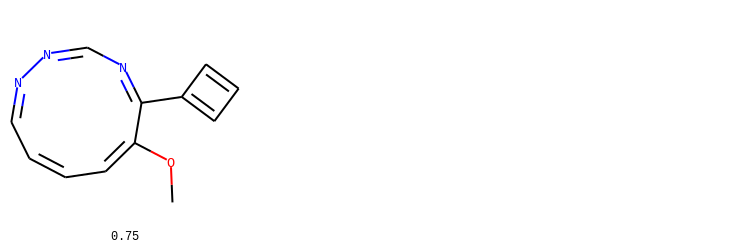

In [100]:
from rdkit.Chem import Draw

Draw.MolsToGridImage([x[0] for x in final_mol_list],
               molsPerRow = 3, 
               subImgSize = (250,250),
               legends = [f"{x[1]:.2f}" for x in final_mol_list])